<a href="https://colab.research.google.com/github/2024-WISET-F16/wiset-ai-models/blob/kwakminjung%2Fmodels/kwakminjung/DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

epoch = 0, current loss = 91019.3750
current test loss = 158893.4062
epoch = 100, current loss = 2480.1406
current test loss = 4602.8931
epoch = 200, current loss = 1737.3495
current test loss = 3115.0220
epoch = 300, current loss = 1236.0032
current test loss = 1990.6842
epoch = 400, current loss = 960.1306
current test loss = 1252.6006
epoch = 500, current loss = 872.8106
current test loss = 1022.4354
epoch = 600, current loss = 825.3729
current test loss = 948.5536
epoch = 700, current loss = 782.6182
current test loss = 844.0911
epoch = 800, current loss = 734.1781
current test loss = 752.6415
epoch = 900, current loss = 710.3621
current test loss = 663.2510
epoch = 1000, current loss = 652.1874
current test loss = 590.6232
epoch = 1100, current loss = 650.2368
current test loss = 541.5215
epoch = 1200, current loss = 626.8453
current test loss = 494.4023
epoch = 1300, current loss = 579.9340
current test loss = 412.2872
epoch = 1400, current loss = 543.6306
current test loss = 446

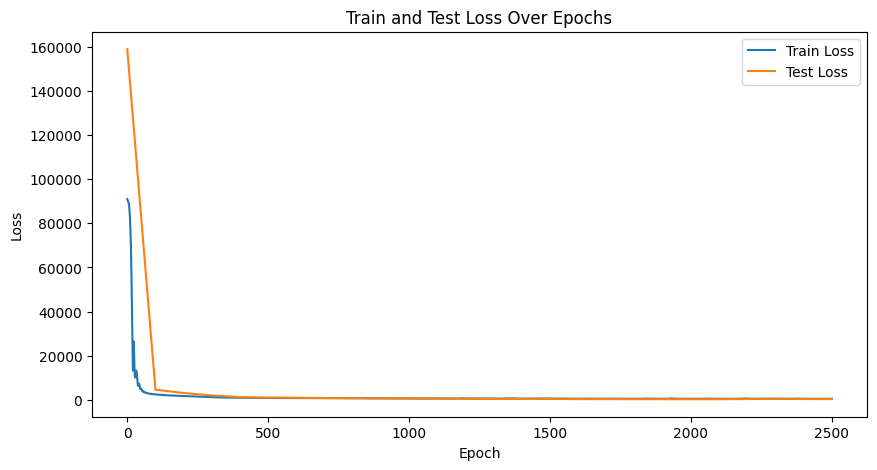

mae: 13.781085014343262


In [10]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from openpyxl import Workbook

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

training_dataset = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/wiset_single_sensor_model_train_data_3.xlsx')
test_dataset = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/wiset_single_sensor_model_test_data_20240407.xlsx')

test_dataset_copy = test_dataset.copy() # test_dataset 복사본

# (datatime) / elevation / azimuth / new_illum_11 / illum(Class) / x / y / point(Identifier by x, y)

X_train_pd = pd.concat([training_dataset.iloc[:, 2:5], training_dataset.iloc[:, 6:8]], axis=1)
y_train_pd = training_dataset.iloc[:, 5]

X_train_np = X_train_pd.astype(np.float32).to_numpy()
# X_train_np[:, 1] = abs(X_train_np[:, 1] - 180)

y_train_np = y_train_pd.astype(np.float32).to_numpy().reshape(-1, 1)  # (batch_size, 1) 형태로 변경

X_train = torch.Tensor(X_train_np).float()
y_train = torch.Tensor(y_train_np).float()

# test dataset 준비
X_test_pd = pd.concat([test_dataset.iloc[:, 1:4], test_dataset.iloc[:, 5:7]], axis=1)
X_test_np = X_test_pd.astype(np.float32).to_numpy()
# X_test_np[:, 1] = abs(X_test_np[:, 1] - 180)

X_test = torch.Tensor(X_test_np).float()

y_test_pd = test_dataset.iloc[:, 4]
y_test_np = y_test_pd.astype(np.float32).to_numpy().reshape(-1, 1)  # (batch_size, 1) 형태로 변경

y_test = torch.Tensor(y_test_np).float()

# DNN 모델
class MyDeepLearningModel(nn.Module):

  def __init__(self, input_nodes, output_nodes):
    super().__init__()
    self.deeplearning_stack = nn.Sequential(
            nn.Linear(input_nodes, input_nodes*4),
            nn.ReLU(),
            nn.Linear(input_nodes*4, input_nodes*2),
            nn.ReLU(),
            nn.Linear(input_nodes*2, input_nodes*2),
            nn.ReLU(),
            nn.Linear(input_nodes*2, input_nodes),
            nn.ReLU(),
            nn.Linear(input_nodes, output_nodes)
    )

  def forward(self, data):
    prediction = self.deeplearning_stack(data)
    return prediction

deeplearning_model = MyDeepLearningModel(5, 1)

# loss function & optimizer
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(deeplearning_model.parameters(), lr=1e-2)

# 학습
early_stopping_epochs=5
best_loss=float('inf')
early_stop_cnt=0

train_loss_list=[]
test_loss_list=[]
nums_epoch=10000
eval_interval=100

for epoch in range(nums_epoch):

  deeplearning_model.train()

  prediction=deeplearning_model(X_train)
  loss = loss_function(prediction, y_train)

  train_loss_list.append(loss.item())

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # 평가
  if epoch%eval_interval==0:
    print(f'epoch = {epoch}, current loss = {loss.item():.4f}')

    deeplearning_model.eval()
    with torch.no_grad():
      test_predictions = deeplearning_model(X_test)
      test_loss = loss_function(test_predictions, y_test)
      test_loss_list.append(test_loss.item())

      print(f'current test loss = {test_loss.item():.4f}')

      if test_loss < best_loss:
        best_loss = test_loss
        early_stop_cnt = 0
      else:
        early_stop_cnt += 1

      if early_stop_cnt >= early_stopping_epochs:
        print(f'Early stopping at epoch {epoch}')
        break

plt.figure(figsize=(10, 5))
plt.plot(range(len(train_loss_list)), train_loss_list, label='Train Loss')
plt.plot(range(0, len(train_loss_list), eval_interval), test_loss_list, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Test Loss Over Epochs')
plt.legend()
plt.show()

test_predictions_np=test_predictions.detach().numpy()

mae=mean_absolute_error(y_test_np[:,0], test_predictions_np[:,0])
print(f'mae: {mae}')

test_dataset_copy['predicted_illum']=test_predictions_np
wb=Workbook()
ws=wb.active
ws.title="Predicted values"
column=['datetime', 'elevation', 'azumith', 'new_illum_11', 'illum', 'x', 'y', 'point', 'predicted_illum']
ws.append(column)
for index, row in test_dataset_copy.iterrows():
  ws.append(list(row))

wb.save('/content/drive/MyDrive/Colab Notebooks/wiset_single_sensor_model_predicted_values.xlsx')
